In [1]:
import numpy as np # numbers and algebra in python
import pandas as pd # tables and processing tabular data


In [2]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor


In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [4]:
dirPath = './archive/CMaps/'

train = pd.read_csv(dirPath + 'train_FD001.txt',sep='\s+',names=col_names)
test = pd.read_csv(dirPath + 'test_FD001.txt',sep='\s+',names=col_names)
y_test = pd.read_csv(dirPath + 'RUL_FD001.txt',sep='\s+',header=None)

In [5]:
train[index_names].groupby('unit_number').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [6]:
def gate_the_RUL(train,cap=150):
    # Rectifier
    train['RUL'] = np.minimum(train['RUL'],cap)
    return train

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

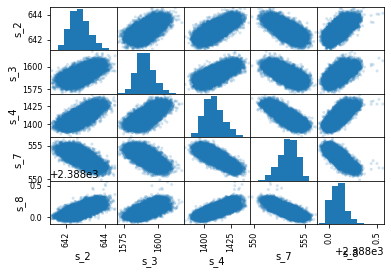

In [7]:
# Here are a small selection of useful looking signals, along with our taregt (RUL)
good_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8']
pd.plotting.scatter_matrix(train.loc[:,good_sensors], alpha=0.2)
plt.show()

As we discussed last week, we can gate the RUL during training if we "don't care about it above a threshold".
Consider histograms later in this script to understand why

In [8]:
train = add_remaining_useful_life(train)
train = gate_the_RUL(train,cap=150)

train[index_names+['RUL']] # last thing in cell prints out

,unit_number,time_cycles,RUL
0,1,1,150
1,1,2,150
2,1,3,150
3,1,4,150
4,1,5,150
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


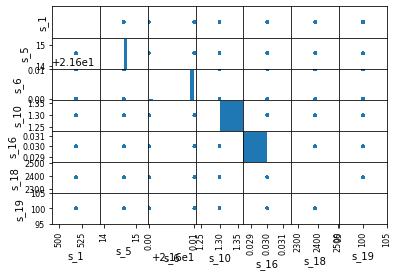

In [9]:
# these seem not worth keeping
import warnings
warnings.filterwarnings("ignore")
# drop_sensors = ['s_1','s_5','s_16','s_18','s_19'] # as per last week..
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19'] # new bad signals noted. 

pd.plotting.scatter_matrix(train.loc[:,drop_sensors])
plt.show()

In [10]:
# this time let's keep the cycles (normalised) showing current engine life
drop_labels = setting_names+drop_sensors # ['unit_number'] was index_names
 # last time we dropped ['unit_number'] here

In [11]:
X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

In [12]:
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [13]:
X_test

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606
96,97,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953
97,98,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608
98,99,97,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8150.38,8.4003,391,38.95,23.3595


In [14]:
"""
X_train = X_train.groupby('unit_number').rolling(2,min_periods=1).sum()
X_test = X_test.groupby('unit_number').rolling(2,min_periods=1).sum()
drop_labels = ['unit_number']
X_train = X_train.drop(drop_labels, axis=1)
X_test = X_test.drop(drop_labels, axis=1)
"""

"\nX_train = X_train.groupby('unit_number').rolling(2,min_periods=1).sum()\nX_test = X_test.groupby('unit_number').rolling(2,min_periods=1).sum()\ndrop_labels = ['unit_number']\nX_train = X_train.drop(drop_labels, axis=1)\nX_test = X_test.drop(drop_labels, axis=1)\n"

In [15]:
# zero-centered normalise (standardise or zscore)

X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [16]:
from sklearn.decomposition import PCA
reduce_dim = 5

pca = PCA(n_components=reduce_dim)
pca.fit(X_train)

print(pca.explained_variance_ratio_)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

[0.59276809 0.13579847 0.06275434 0.02735979 0.02573127]


In [17]:
img_rows, img_cols = 1, reduce_dim
input_shape = (img_rows, img_cols, 1)

In [19]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
# X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_val = X_val.astype('float32')

In [20]:
model = tf.keras.models.Sequential()

In [21]:
X_train.shape

(20631, 1, 5, 1)

In [23]:
model.add(tf.keras.layers.Conv2D(32, kernel_size=(1, 5),padding='same',               
                 input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=(1,3), strides=(1),name="c2",padding='same',
        ),)
model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=(1,3), strides=(1),name="c3",padding='same',
        ),)

model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(
        tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1,3), strides=(1),name="c4",padding='same',
        ),)
model.add(tf.keras.layers.BatchNormalization()) # bnorm
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))

In the next section we define a custom metric, we manually split and shuffle data

In [24]:
import keras.backend as K # this will let us easily view rmse during training
def root_mean_squared_error(y_true, y_pred):
    # root_mean_squared_error as metric in compile
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 



In [25]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mae'])
# note using root_mean_squared_error here can cause issue copying model later without config set, using grid search.
# what if we used mae for loss..

In [26]:
# note we could have said validation_split,0.2. We can set shuffle here too... shuffle=True,
history = model.fit(X_train, y_train ,batch_size = 128, epochs = 30,verbose=1,
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                                                     verbose=0, mode='min')],
                  validation_split=0.2)


Epoch 1/30
129/129 [==============================] - 2s 6ms/step - loss: 8635.5518 - mean_squared_error: 8635.5518 - mae: 83.9183 - val_loss: 10084.5557 - val_mean_squared_error: 10084.5557 - val_mae: 89.7633
Epoch 2/30
129/129 [==============================] - 1s 4ms/step - loss: 4614.3418 - mean_squared_error: 4614.3418 - mae: 60.4815 - val_loss: 4504.1753 - val_mean_squared_error: 4504.1753 - val_mae: 59.3941
Epoch 3/30
129/129 [==============================] - 1s 4ms/step - loss: 1532.6274 - mean_squared_error: 1532.6274 - mae: 32.9417 - val_loss: 1163.2115 - val_mean_squared_error: 1163.2115 - val_mae: 28.7181
Epoch 4/30
129/129 [==============================] - 1s 4ms/step - loss: 519.2488 - mean_squared_error: 519.2488 - mae: 17.7318 - val_loss: 691.8394 - val_mean_squared_error: 691.8394 - val_mae: 21.5929
Epoch 5/30
129/129 [==============================] - 1s 4ms/step - loss: 407.0669 - mean_squared_error: 407.0669 - mae: 15.0500 - val_loss: 612.2381 - val_mean_squared_e

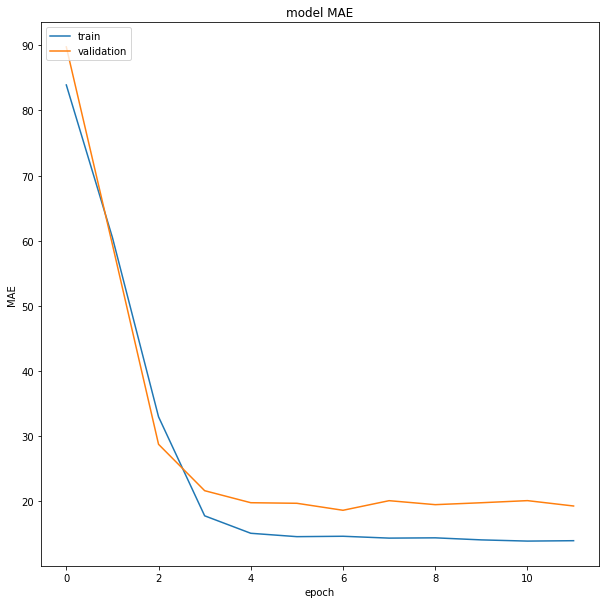

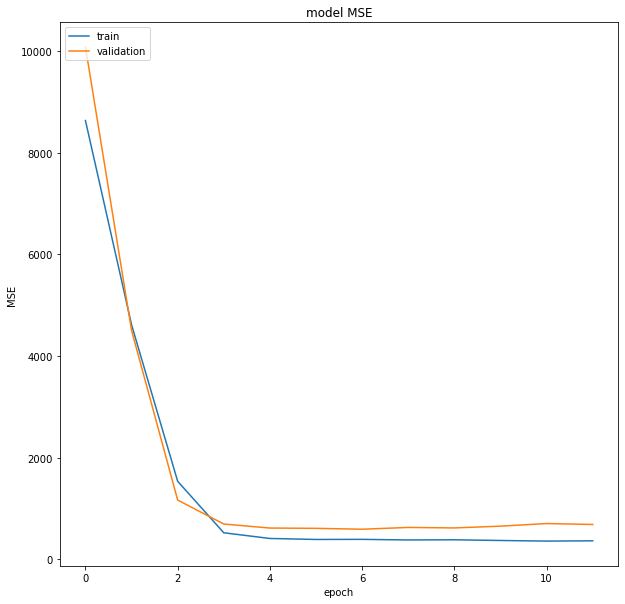

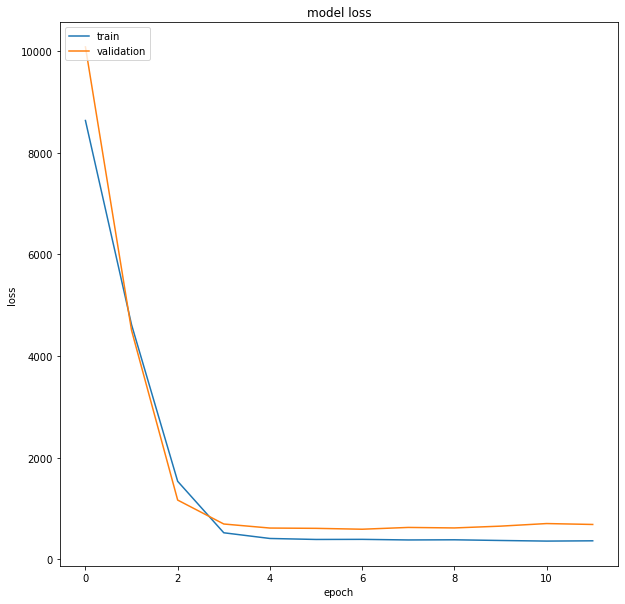

In [27]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_rmse.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') 
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [28]:
model_pred = model.predict(X_test)

4/4 [==============================] - 0s 1ms/step


In [29]:
from sklearn.metrics import r2_score

In [30]:
r2_score(y_test,model_pred)

0.5402644512527323

In [31]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  28.1762904437574


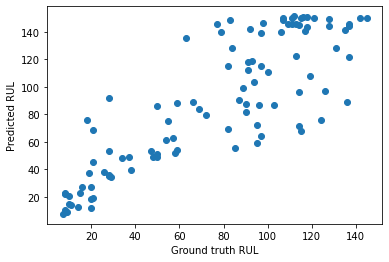

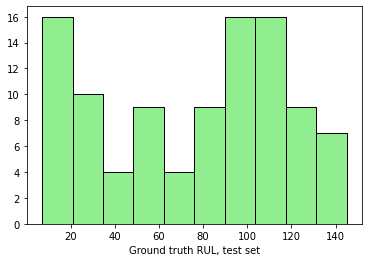

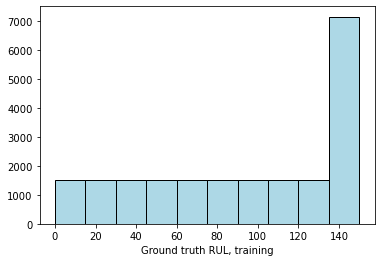

In [32]:
plt.scatter(y_test,model_pred)
plt.xlabel("Ground truth RUL")
plt.ylabel("Predicted RUL")
plt.show()

plt.hist(y_test, color = "lightgreen", ec="black")
plt.xlabel("Ground truth RUL, test set")
plt.show()

plt.hist(y_train, color = "lightblue", ec="black")
plt.xlabel("Ground truth RUL, training")
plt.show()

In [ ]:
model.summary()

In [ ]:
# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [10, 15, 20]
learn_rate = [0.0001, 0.001, 0.01]
momentum = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum, batch_size=batch_size, epochs=epochs)
# param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [ ]:
model2 = KerasRegressor(build_fn=model, epochs=100, batch_size=128, verbose=0)
grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')

grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
plt.plot(means)
plt.title("Mean square error")
plt.show()

plt.plot(np.sqrt(np.abs(means)))
plt.title("Root Mean square error")
plt.show()

In [ ]:
model_gs = grid.best_estimator_
model_pred = model_gs.predict(X_test)

In [ ]:
r2_score(y_test,model_pred)

In [ ]:
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

This next section may be easier to view in a new window, or see image noted in powerpoint.
It shows why we removed certain signals

In [ ]:
pd.plotting.scatter_matrix(train,figsize=[20,20])
plt.show()